#Debutanizer

MSc. Eng. Josmell Cordova Claros

<Purpose:> Evalute differents Machine Learning (ML) algorithms to develop a soft (virtual) sensor for the prediction of the C4 content in the bottoms of a debutanizer column using operation data of the column, .

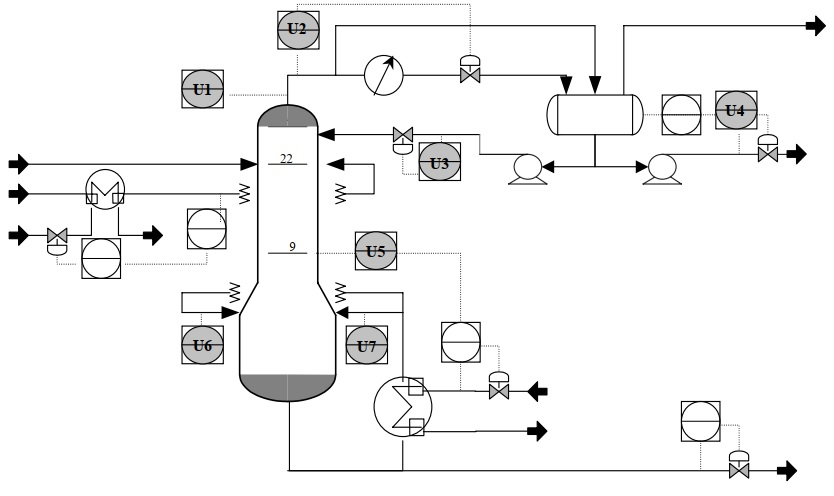

Dataset source: https://www.springer.com/gp/book/9781846284793

Dataset download link: https://github.com/josmellcordova/Debutanizer/blob/770bc59f68a254e8be4511b17aca2160e8a27e82/debutanizer.csv


**Input variables**
*   x1: Top temperature
*   x2: Top pressure
*   x3: Reflux flow
*   x4: Flow to next process
*   x5: 6th tray temperature
*   x6: Bottom temperature
*   x7: Bottom temperature

**Output variable**
*   y: C4 content

## Import the required libraries

In [47]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Machine learning libraries (from sklearn)

# Linear regression
from sklearn.linear_model import LinearRegression 

# Regularization
from sklearn.linear_model import Ridge   
from sklearn.linear_model import Lasso  
from sklearn.linear_model import ElasticNet  

# Non-linear regression
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.tree import DecisionTreeRegressor   
from sklearn.svm import SVR  # Support Vector regression


# Ensemble
from sklearn.ensemble import AdaBoostRegressor   
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.ensemble import RandomForestRegressor   
from sklearn.ensemble import ExtraTreesRegressor     

# Model evaluation
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import KFold  
from sklearn.model_selection import cross_val_score   

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error   
from sklearn.metrics import r2_score  

## Load the dataset

In [49]:
url = 'https://raw.githubusercontent.com/josmellcordova/Debutanizer/main/debutanizer.csv'
names = ['top_temp', 'top_pres', 'reflux_flow', 'flow_to_next', '6th_tray_temp', 'btms_temp1', 'btms_temp2', 'C4_content_btms']
dataset = pd.read_csv(url, names=names)

## Exploratory Data Analysis

In [50]:
# data shape
dataset.shape

(2394, 8)

In [51]:
# data type
dataset.dtypes

top_temp           float64
top_pres           float64
reflux_flow        float64
flow_to_next       float64
6th_tray_temp      float64
btms_temp1         float64
btms_temp2         float64
C4_content_btms    float64
dtype: object

In [52]:
dataset.describe()

,top_temp,top_pres,reflux_flow,flow_to_next,6th_tray_temp,btms_temp1,btms_temp2,C4_content_btms
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,0.283882,0.667845,0.598462,0.435952,0.658082,0.620737,0.589403,0.267789
std,0.103127,0.057695,0.198576,0.138237,0.127047,0.165110,0.173248,0.158946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224000,0.654000,0.500000,0.363000,0.609000,0.482000,0.445000,0.169000
50%,0.264000,0.672000,0.624000,0.396000,0.695000,0.639500,0.601000,0.247000
75%,0.325750,0.691000,0.742750,0.518000,0.730000,0.755000,0.741000,0.318000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Note:> Data is scaled from 0 to 1.

In [53]:
dataset.head(5)

,top_temp,top_pres,reflux_flow,flow_to_next,6th_tray_temp,btms_temp1,btms_temp2,C4_content_btms
0,0.269,0.651,0.833,0.583,0.785,0.843,0.822,0.180
1,0.268,0.650,0.852,0.578,0.776,0.839,0.822,0.177
2,0.268,0.660,0.824,0.572,0.765,0.808,0.786,0.174
3,0.267,0.668,0.808,0.566,0.753,0.800,0.786,0.172
4,0.267,0.647,0.762,0.560,0.745,0.773,0.746,0.167


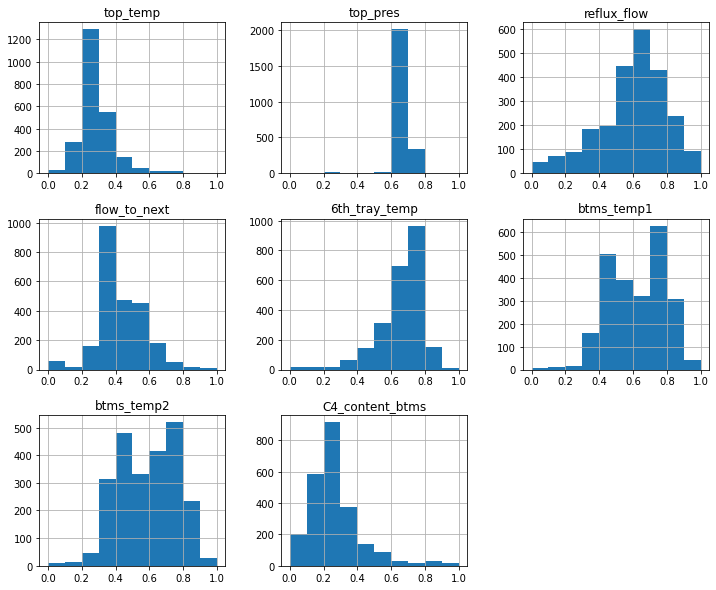

In [54]:
# Variables distribution (histogram)
dataset.hist(figsize=[12,10])
plt.show()

## Correlation Matrix

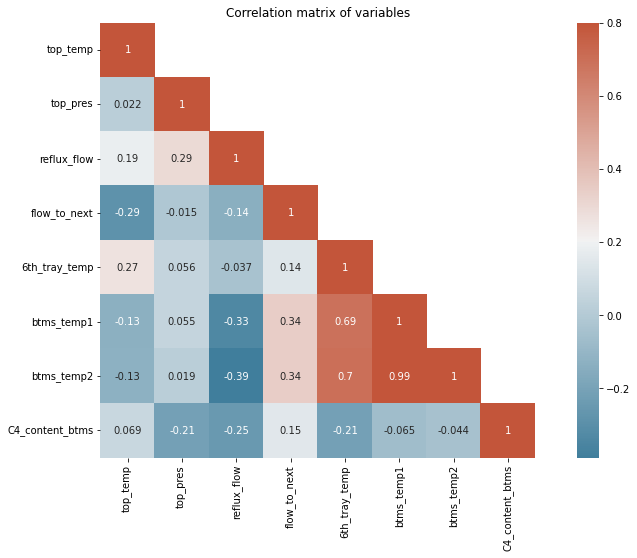

In [55]:
import seaborn as sns
# Compute the correlation matrix
correlations=dataset.corr()
# Generate a mask for the upper triangle
mask=np.array(correlations)
mask[np.tril_indices_from(mask)]=False
# Set up the matplotlib figure
fig,ax=plt.subplots(figsize=(15,8))
# Heat map for correlation matrix of variables
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlations,cmap=cmap,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of variables')
plt.show()

<Note:> Because the correlation between `btms_temp1` and `btms_temp2` is near to 1, one of them is eliminated.

In [56]:
# Elimninate btms_temp2 from dataset
dataset.drop(columns='btms_temp2',inplace=True)
dataset.describe()

,top_temp,top_pres,reflux_flow,flow_to_next,6th_tray_temp,btms_temp1,C4_content_btms
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,0.283882,0.667845,0.598462,0.435952,0.658082,0.620737,0.267789
std,0.103127,0.057695,0.198576,0.138237,0.127047,0.165110,0.158946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224000,0.654000,0.500000,0.363000,0.609000,0.482000,0.169000
50%,0.264000,0.672000,0.624000,0.396000,0.695000,0.639500,0.247000
75%,0.325750,0.691000,0.742750,0.518000,0.730000,0.755000,0.318000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train and Test Data Split

In [57]:
# Split the dataset into inputs and ouput
array = dataset.values
X = array[:,0:6]  # inputs
y = array[:,6]    # output
               
# Split the dataset into the train and test data
test_size = 0.20    # ratio of 80/20
seed = 7   # for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)      

print('Train: %d samples. Test: %d samples' % (len(y_train), len(y_test)))

Train: 1915 samples. Test: 479 samples


## Evaluate different ML algorithms in Cross Validation

Cross-validation (CV) is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.

In [58]:
# Import library for standarization (mean 0 and std 1)
from sklearn.preprocessing import StandardScaler  

In [59]:
# Import library for pipeline
from sklearn.pipeline import make_pipeline

# Set the pool of Machine Learning Pipelines to evaluate (scaler + ML algorithm)
pipelines = []
pipelines.append(('pipLinearReg', make_pipeline(StandardScaler(), LinearRegression())))
pipelines.append(('pipRidge', make_pipeline(StandardScaler(), Ridge())))
pipelines.append(('pipLasso', make_pipeline(StandardScaler(), Lasso())))
pipelines.append(('pipElasticNet', make_pipeline(StandardScaler(), ElasticNet())))
pipelines.append(('pipKNN', make_pipeline(StandardScaler(), KNeighborsRegressor())))
pipelines.append(('pipRegTrees', make_pipeline(StandardScaler(), DecisionTreeRegressor())))
pipelines.append(('pipSVR', make_pipeline(StandardScaler(), SVR())))
pipelines.append(('pipABst', make_pipeline(StandardScaler(), AdaBoostRegressor())))
pipelines.append(('pipGrBst', make_pipeline(StandardScaler(), GradientBoostingRegressor())))
pipelines.append(('pipRF', make_pipeline(StandardScaler(), RandomForestRegressor())))
pipelines.append(('pipET', make_pipeline(StandardScaler(), ExtraTreesRegressor())))

In [60]:
# Evaluate each ML pipeline in 10-fold cross validation
results = []
names = []

# Generate the 10-fold partitioning
seed = 7 # for reproducibility    
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  

# Evaluate each pipeline in cross validation with train data
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

pipLinearReg: 0.19661520040658095 (0.06614462847316017)
pipRidge: 0.19662642125256707 (0.06614354203051921)
pipLasso: -0.0057176990839096446 (0.010693075326168734)
pipElasticNet: -0.0057176990839096446 (0.010693075326168734)
pipKNN: 0.7266963398798321 (0.0778197521040698)
pipRegTrees: 0.5823693013225643 (0.05192090567151229)
pipSVR: 0.5536198959893167 (0.0720759861260255)
pipABst: 0.34961196295356783 (0.08798899276650152)
pipGrBst: 0.5643806106397985 (0.07425904742289201)
pipRF: 0.7718752761138428 (0.06310816067570306)
pipET: 0.829496217030217 (0.0430527402984918)


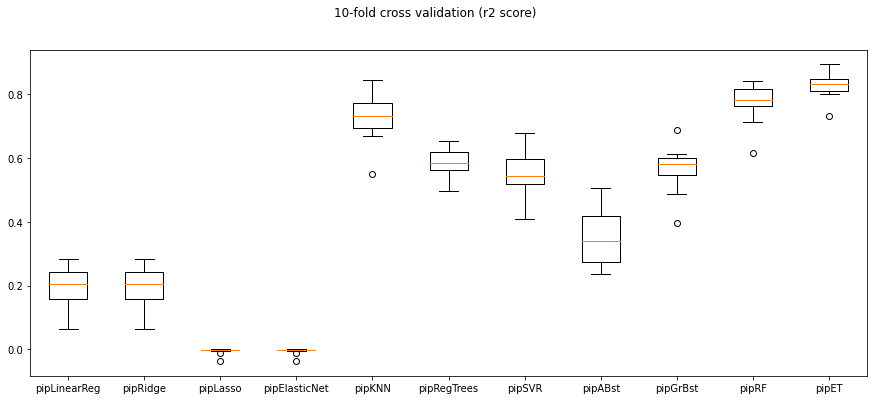

In [61]:
# Cross Validation Results (grafically)
fig = plt.figure(figsize=[15,6])
fig.suptitle('10-fold cross validation (r2 score)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<Note:> The results show the ExtraTreesRegressor (ET) is the best model.

## Train the best model

In [62]:
# Fit the best model with the train data
pipeline = make_pipeline(StandardScaler(), ExtraTreesRegressor()) 
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesregressor',
                 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                     criterion='mse', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False))],
         verbose=False)

## Predict the model

In [63]:
y_predicted = pipeline.predict(X_test) # output predicted with test data

## Model Evaluation Metrics

In [64]:
print("MAE score:", mean_absolute_error(y_test, y_predicted)) # MEA (Mean absolute error)
print("MSE:", mean_squared_error(y_test, y_predicted)) # MSE (Mean squared error)
print("R2 score:", r2_score(y_test, y_predicted))

MAE score: 0.03671476830201811
MSE: 0.0036874380576217346
R2 score: 0.866556312971151


## Prediction Plot

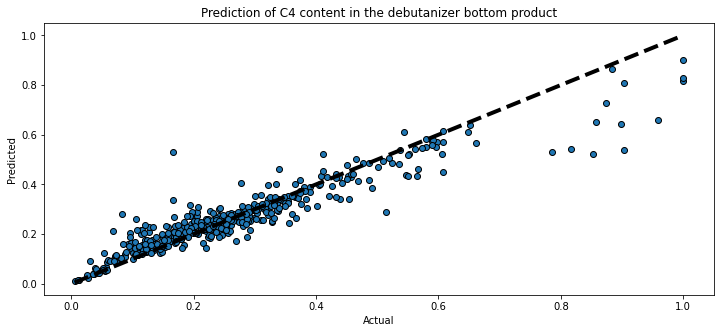

In [65]:
# Plot the actual vs predicted values for the test data
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Prediction of C4 content in the debutanizer bottom product')
plt.show()

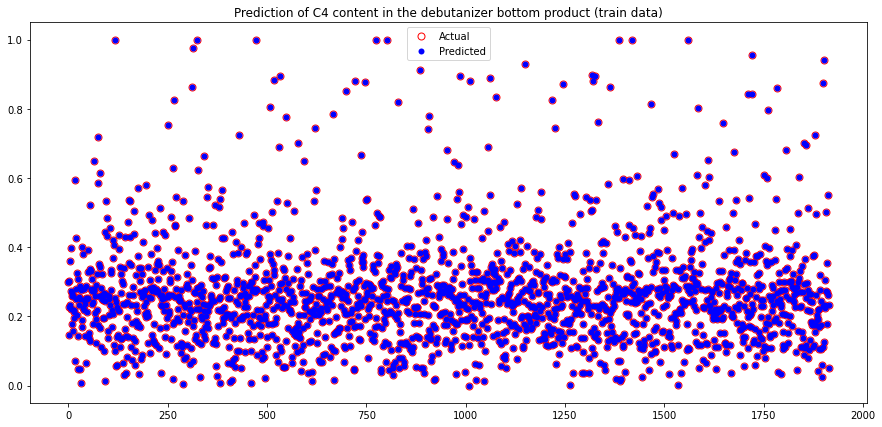

In [66]:
# Prediction of C4 content in the debutanizer bottom product (train data)
y_predicted_train = pipeline.predict(X_train)
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(y_train, linestyle='none', marker='o',markeredgecolor='r' ,markerfacecolor='none', markersize=7)
ax.plot(y_predicted_train, linestyle='none', marker='o', markeredgecolor='none',markerfacecolor='blue')
ax.legend(['Actual','Predicted'])
plt.title('Prediction of C4 content in the debutanizer bottom product (train data)')
plt.show()

<Note:> The above figure shows overfitting for the ExtraTrees Regressor (ET) model, so the `max_depth` is going to be limited between 5 to 15 (see the next section: 'Hyperparameter Optimization').

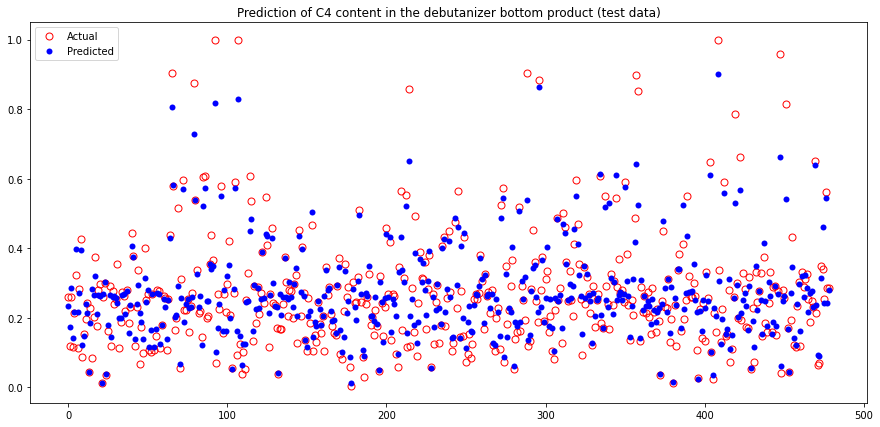

In [67]:
# Prediction of C4 content in the debutanizer bottom product (test data)
y_predicted_test = pipeline.predict(X_test)
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(y_test, linestyle='none', marker='o',markeredgecolor='r' ,markerfacecolor='none', markersize=7)
ax.plot(y_predicted_test, linestyle='none', marker='o', markeredgecolor='none',markerfacecolor='blue')
ax.legend(['Actual','Predicted'])
plt.title('Prediction of C4 content in the debutanizer bottom product (test data)')
plt.show()

## Hyperparameter Optimization

In [68]:
# Load the grid search library
from sklearn.model_selection import GridSearchCV

# Set the values of the hyperparameters to be tested
parameter_grid = dict(max_depth=np.array([5,10,15]), 
                      n_estimators=np.array([20,50,100])) 

# Set the 10-fold CV to evaluate each hyperparameter
seed = 7   
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  

# Set the model 
model = ExtraTreesRegressor(random_state=seed)

# Set the grid seach in cross validation 
grid = GridSearchCV(estimator=model, param_grid=parameter_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, y_train)

# Grid search results
print("Best r2 score: %f with hyperparameter %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best r2 score: 0.787296 with hyperparameter {'max_depth': 15, 'n_estimators': 100}
0.335208 (0.069015) with: {'max_depth': 5, 'n_estimators': 20}
0.340093 (0.067823) with: {'max_depth': 5, 'n_estimators': 50}
0.335156 (0.070266) with: {'max_depth': 5, 'n_estimators': 100}
0.614590 (0.054881) with: {'max_depth': 10, 'n_estimators': 20}
0.624850 (0.049301) with: {'max_depth': 10, 'n_estimators': 50}
0.618418 (0.052443) with: {'max_depth': 10, 'n_estimators': 100}
0.768530 (0.055025) with: {'max_depth': 15, 'n_estimators': 20}
0.783659 (0.047161) with: {'max_depth': 15, 'n_estimators': 50}
0.787296 (0.044420) with: {'max_depth': 15, 'n_estimators': 100}


## Train and evaluate the optimized model

In [69]:
# Train the best model with the optimized hyperparameters 
pipeline = make_pipeline(StandardScaler(), ExtraTreesRegressor(max_depth=15, n_estimators=100)) 
pipeline.fit(X_train, y_train)

# Model Evaluation Metrics
y_predicted = pipeline.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_predicted))
print("MSE:", mean_squared_error(y_test, y_predicted))
print("R2 score:", r2_score(y_test, y_predicted))

MAE: 0.042493099571227606
MSE: 0.004096895862129112
R2 score: 0.8517385565065332


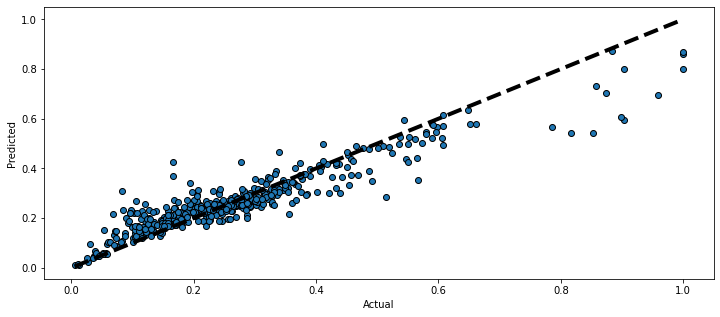

In [70]:
# Prediction Plot
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

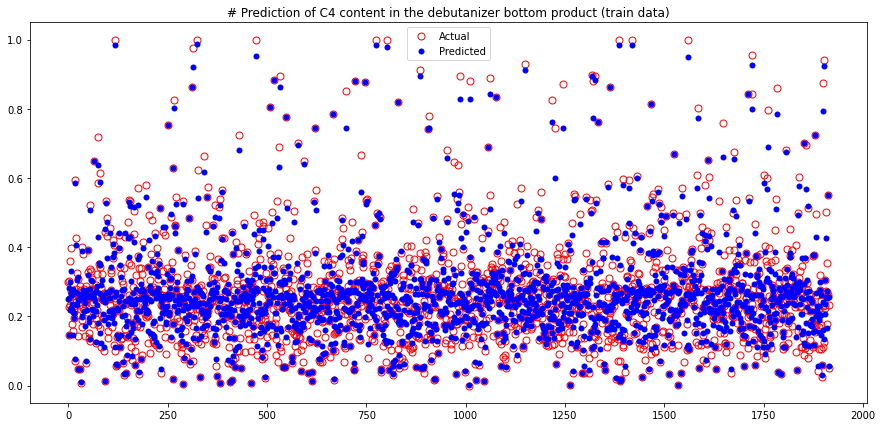

In [71]:
# Prediction of C4 content in the debutanizer bottom product (train data)
y_predicted_train = pipeline.predict(X_train)
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(y_train, linestyle='none', marker='o',markeredgecolor='r' ,markerfacecolor='none', markersize=7)
ax.plot(y_predicted_train, linestyle='none', marker='o', markeredgecolor='none',markerfacecolor='blue')
ax.legend(['Actual','Predicted'])
plt.title('# Prediction of C4 content in the debutanizer bottom product (train data)')
plt.show()

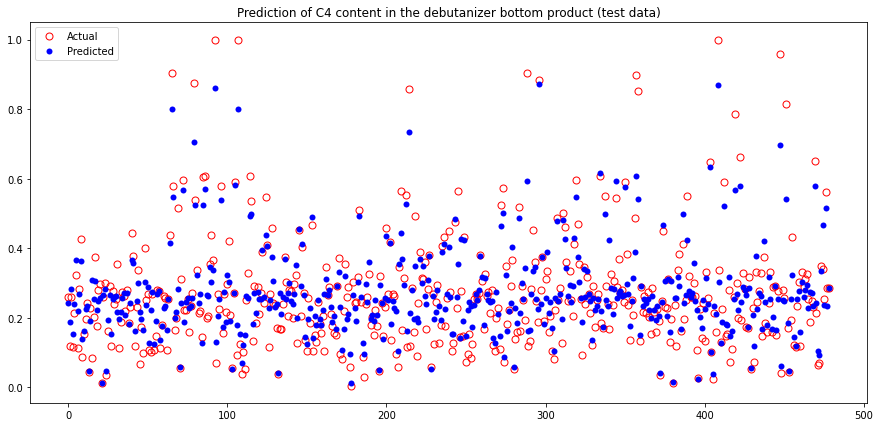

In [72]:
# Prediction of C4 content in the debutanizer bottom product (test data)
y_predicted_test = pipeline.predict(X_test)
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(y_test, linestyle='none', marker='o',markeredgecolor='r' ,markerfacecolor='none', markersize=7)
ax.plot(y_predicted_test, linestyle='none', marker='o', markeredgecolor='none',markerfacecolor='blue')
ax.legend(['Actual','Predicted'])
plt.title('Prediction of C4 content in the debutanizer bottom product (test data)')
plt.show()

## Conclusion

A soft (virtual) sensor was developed for the prediction of C4 content in the debutanizer bottom product using operating data from the column. The ExtraTree Regressor resulted to be the model with the best performance, with a R2 score around 85% 